In [ ]:
# @title Импортирование необходимых библиотек

import numpy as np
import pandas as pd
import math
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy.stats import linregress
from scipy.stats import chi2

In [ ]:
# @title Вспомогательные функции

def r(x):
  return round(x, 3)

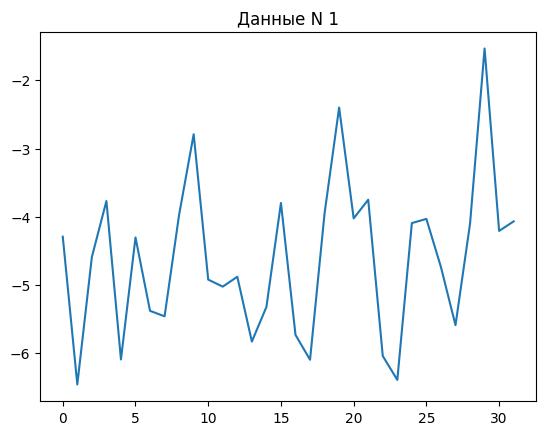

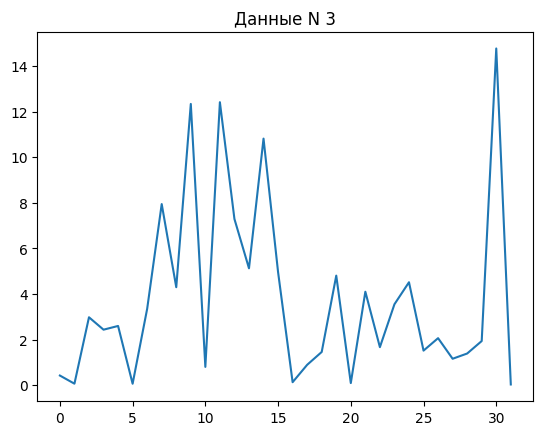

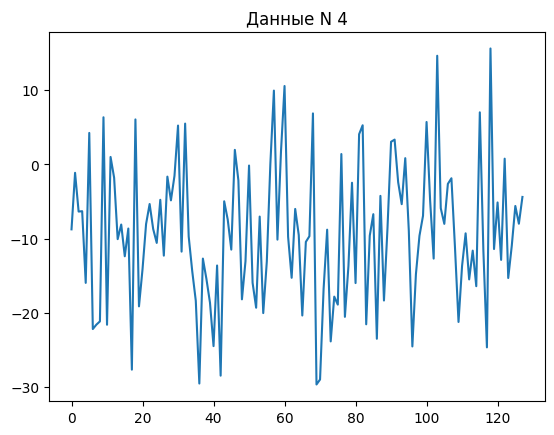

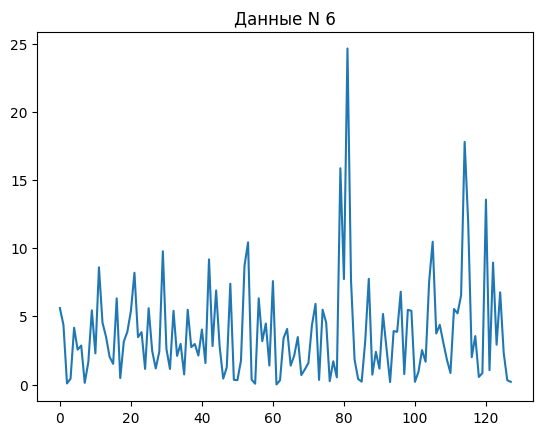

In [ ]:
# @title Загрузка данных

numbers = [1,3,4,6]
data = []
data_dir = '/content/drive/MyDrive/mirea-ptms-data/03'
for i in numbers:
  with open(f"{data_dir}/{str(i)}.txt", 'r') as f:
    data_cur = []
    for line in f:
      data_cur.append(float(line[:-2]))
    data.append(data_cur)
    plt.plot(data_cur)
    plt.title(f'Данные N {i}')
    plt.show()

In [ ]:
# @title Класс для работы с интервалами

class Intervals():
  data = []
  n = 0
  m = 0
  h = 0
  middles = []
  bounds = []
  bin_edges = []
  bin_indices = []
  frequencies = []
  interval_counts = []

  def __init__(self, data):
    self.data = data
    self.n = len(data)
    self._calculate_amount_of_intervals()
    self._calculate_bounds()
    self._calculate_distribution()
    self._calculate_frequency()
    self._create_interval_string()

  def plot_histogramm(self):
    plt.figure(figsize=(5, 3))
    plt.title('Распределение по интервалам')
    plt.xlabel('Интервал')
    plt.ylabel('Частота')
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.bar(self.intervals_names, self.frequencies)

  def _calculate_amount_of_intervals(self):
    self.m = int(1 + 3.322 * math.log10(self.n))
    self.h = (max(self.data) - min(self.data)) / self.m

  def _calculate_bounds(self):
    calc_end = lambda x: x + self.h
    calc_mid = lambda x, y: (x + y) / 2

    start = min(self.data)
    end = calc_end(start)

    bounds = [[start, end]]
    self.middles = [calc_mid(start, end)]
    for i in range(self.m - 1):
        start, end = end, calc_end(end)
        bounds.append([start, end])
        self.middles.append(calc_mid(start, end))

    self.bounds = np.array(bounds)

  def _calculate_distribution(self):
    self.bin_edges = np.unique(self.bounds)[:-1]
    self.bin_indices = np.digitize(self.data, self.bin_edges)

  def _calculate_frequency(self):
    indexes_to_delete = [i for i in range(self.m) if i + 1 not in self.bin_indices]

    self.bin_edges = np.delete(self.bin_edges, indexes_to_delete, axis=0)
    self.middles = np.delete(self.middles, indexes_to_delete, axis=0)
    self.bounds = np.delete(self.bounds, indexes_to_delete, axis=0)

    _, self.interval_counts = np.unique(self.bin_indices, return_counts=True)

    self.frequencies = [i / self.n for i in self.interval_counts]

  def _create_interval_string(self):
    self.intervals_names = []
    for start, end in self.bounds:
      self.intervals_names.append(f'[{r(start)}, {r(end)}]')

In [ ]:
# @title Класс для работы с критерием Пирсона

class Pearson:
  intervals = None
  data = []
  n = 0
  alpha = 0.05
  mean = 0
  s = 0
  lmb = 0

  p_norm = []
  p_exp = []

  chi2_norm = 0
  chi2_exp = 0
  chi2_crit_norm = 0
  chi2_crit_exp = 0

  def __init__(self, data):
    self.intervals = Intervals(data)
    self.data = data
    self.n = self.intervals.n
    self.mean = sum(data) / self.n
    self.s = np.std(data, ddof = 1)
    self.lmb = 1 / self.mean
    self._calculate_p_norm()
    self._calculate_p_exp()
    self._calculate_chi2_norm()
    self._calculate_chi2_exp()
    self._calculate_chi2_crit()

  def print_distribution_type(self):
      print(
        f'Критическое значение Chi2 для экспоненциального распределения: '
        f'{self.chi2_crit_exp}, '
        f'полученное значение: {self.chi2_exp}, '
        f'критическое значение Chi2 для нормального распределения: '
        f'{self.chi2_crit_norm}, '
        f'полученное значение: {self.chi2_norm}'
      )

  def _calculate_p_norm(self):
    self.p_norm = []
    for x, y in self.intervals.bounds:
        cur = norm.cdf((y - self.mean) / self.s) -\
          norm.cdf((x - self.mean) / self.s)
        self.p_norm.append(cur * self.n)

  def _calculate_p_exp(self):
    self.p_exp = []
    for x, y in self.intervals.bounds:
      cur = math.exp(-1 * self.lmb * x) - math.exp(-1 * self.lmb * y)
      self.p_exp.append(cur * self.n)

  def _calculate_chi2_norm(self):
    self.chi2_norm = 0
    for count, p in zip(self.intervals.interval_counts, self.p_norm):
        top = (count - p) ** 2
        self.chi2_norm += top / p

  def _calculate_chi2_exp(self):
      self.chi2_exp = 0
      for count, p in zip(self.intervals.interval_counts, self.p_exp):
          top = (count - p) ** 2
          self.chi2_exp += top / p

  def _calculate_chi2_crit(self):
      self.chi2_crit_norm = chi2.ppf(1 - self.alpha, self.intervals.m - 2)
      self.chi2_crit_exp = chi2.ppf(1 - self.alpha, self.intervals.m - 1)

Данные N 1:
Критическое значение Chi2 для экспоненциального распределения: 11.070497693516351, полученное значение: -194.31693130313994, критическое значение Chi2 для нормального распределения: 9.487729036781154, полученное значение: 2.5234662736559907


Данные N 3:
Критическое значение Chi2 для экспоненциального распределения: 11.070497693516351, полученное значение: 10.631177876551291, критическое значение Chi2 для нормального распределения: 9.487729036781154, полученное значение: 34.51486513440228


Данные N 4:
Критическое значение Chi2 для экспоненциального распределения: 14.067140449340169, полученное значение: -1070.1882549464071, критическое значение Chi2 для нормального распределения: 12.591587243743977, полученное значение: 3.147947632088827


Данные N 6:
Критическое значение Chi2 для экспоненциального распределения: 14.067140449340169, полученное значение: 5.587957945836934, критическое значение Chi2 для нормального распределения: 12.591587243743977, полученное значение: 5584

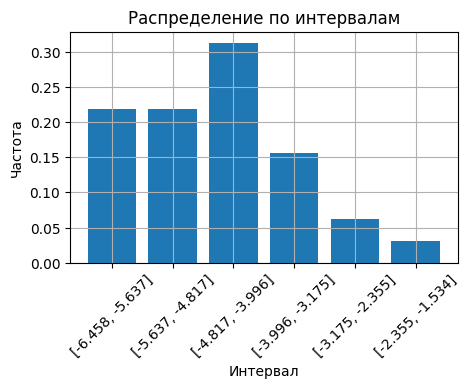

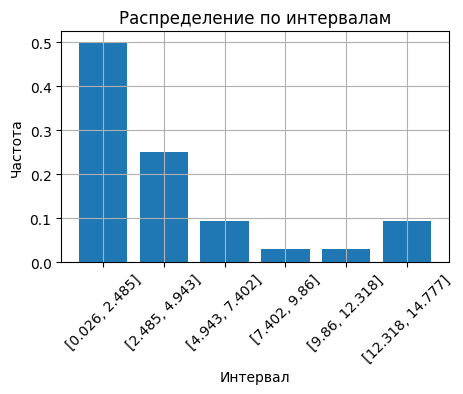

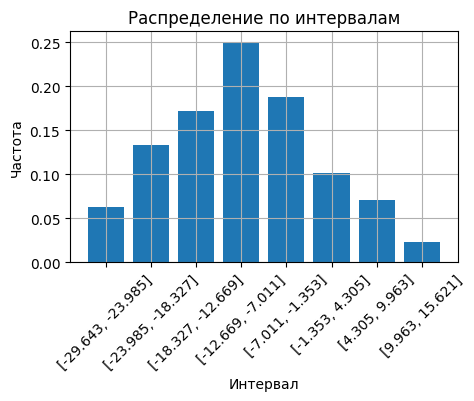

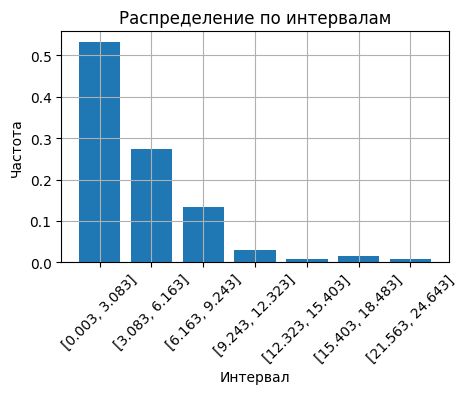

In [ ]:
# @title Получение результатов по критерию Пирсона
for i in range(len(numbers)):
    print(f'Данные N {numbers[i]}:')
    pearson = Pearson(data[i])
    pearson.intervals.plot_histogramm()
    pearson.print_distribution_type()
    print('\n')

In [ ]:
# @title Класс для работы с анаморфозой

class Anamorphosis:
  data = []
  mean = 0
  lmb = 0
  intervals = None

  def __init__(self, data):
    self.data = data
    self.mean = np.mean(data)
    self.lmb = 1 / self.mean
    self.intervals = Intervals(data)

  def plot_distributions(self):
    log_frequencies = self._log_transform()
    transformed_x_normal = self._calc_transformed_x_normal()
    transformed_x_exponential = self._calc_transformed_x_exponential()

    r_squared_normal, \
      slope_normal, \
      intercept_normal = self._calc_r2(transformed_x_normal, log_frequencies)

    r_squared_exponential, \
      slope_exponential, \
      intercept_exponential = self._calc_r2(
        transformed_x_exponential, log_frequencies
      )

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(
      transformed_x_normal,
      log_frequencies,
      color='blue',
      label='Log(Частота)'
    )
    plt.plot(
      transformed_x_normal,
      slope_normal * transformed_x_normal + intercept_normal,
      color='red',
      label=f'Анаморфоза: R²={r_squared_normal:.3f}'
    )
    plt.xlabel('Средние точки интервалов')
    plt.ylabel('Log(Частота)')
    plt.title('Анаморфоза для нормального распределения')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.scatter(
      transformed_x_exponential,
      log_frequencies,
      color='blue',
      label='Log(Частота)'
    )
    plt.plot(
      transformed_x_exponential,
      slope_exponential * transformed_x_exponential + intercept_exponential,
      color='red',
      label=f'Анаморфоза: R²={r_squared_exponential:.3f}'
    )
    plt.xlabel('Средние точки интервалов')
    plt.ylabel('Log(Частота)')
    plt.title('Анаморфоза для экспоненциального распределения')
    plt.legend()

    plt.tight_layout()
    plt.show()

  def _log_transform(self):
    return [math.log(x) if x != 0 else 0 for x in self.intervals.frequencies]

  def _calc_transformed_x_normal(self):
    return ((self.intervals.middles - self.mean) ** 2) / (2 * self.mean ** 2)

  def _calc_transformed_x_exponential(self):
    return np.array(self.intervals.middles)

  def _calc_r2(self, x, y):
    slope, intercept, r_value, _, _ = linregress(x, y)
    return r_value ** 2, slope, intercept

Данные N 1:


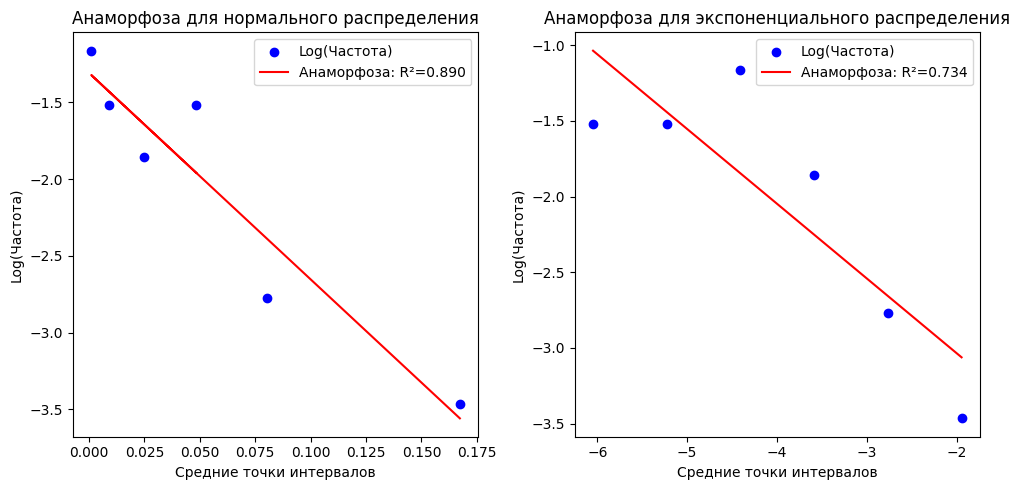



Данные N 3:


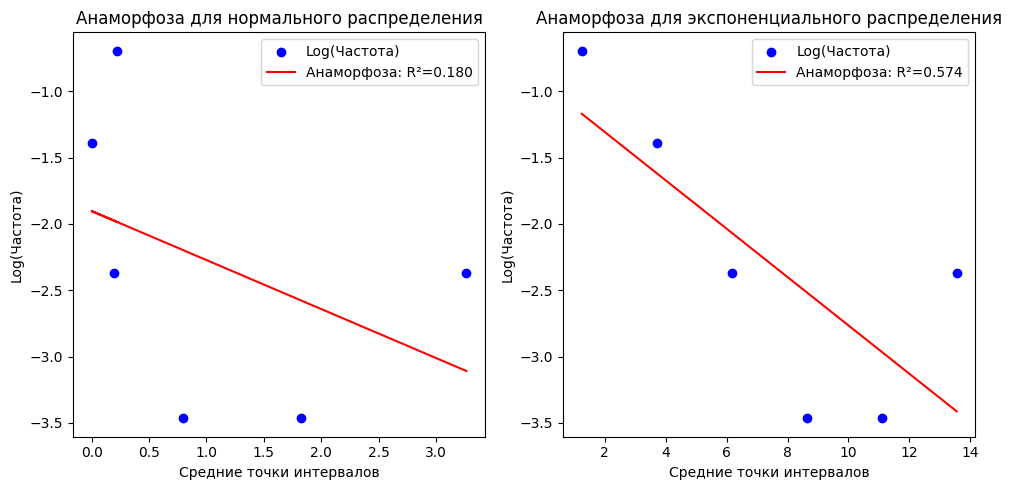



Данные N 4:


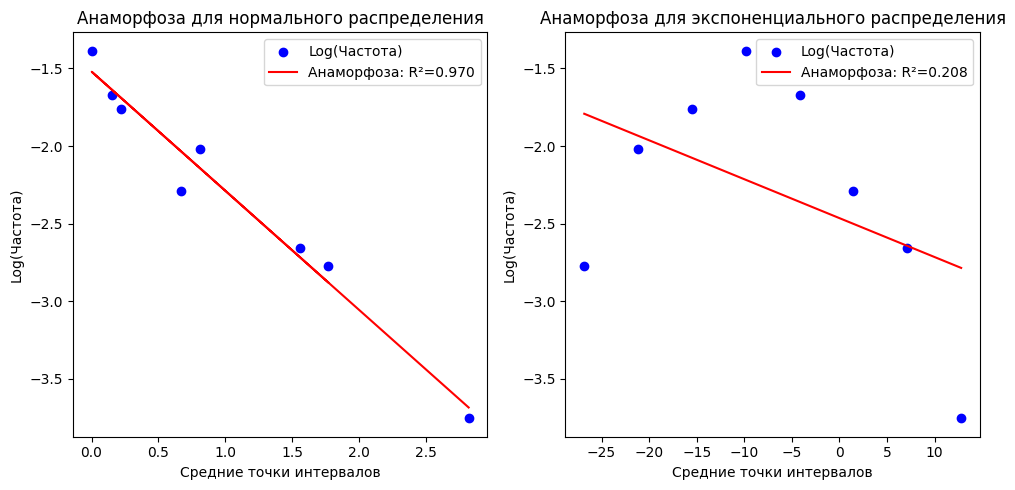



Данные N 6:


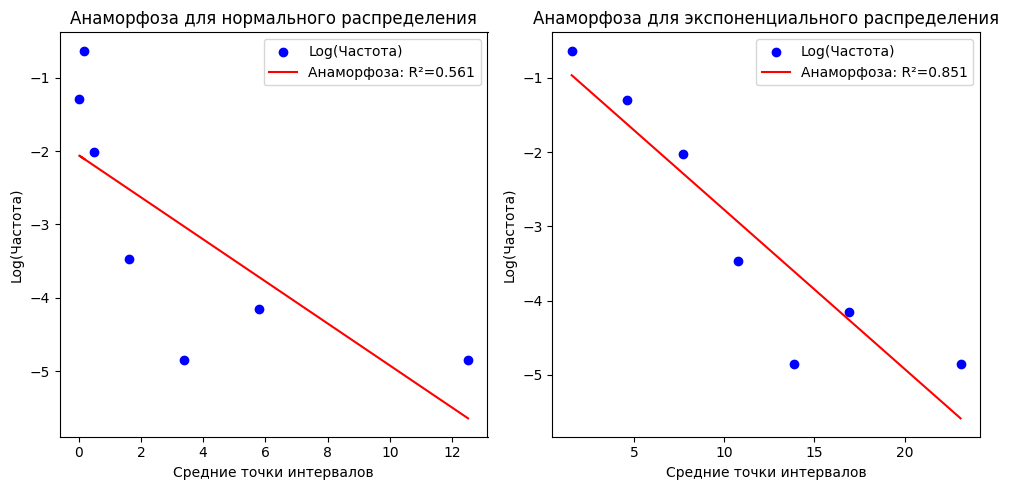

In [ ]:
# @title Вывод результатов для анаморфоз

for i in range(len(numbers)):
    print(f'Данные N {numbers[i]}:')
    anamorphosis = Anamorphosis(data[i])
    anamorphosis.plot_distributions()
    print('\n')